In [ ]:
#|default_exp callback.cutmixup

In [ ]:
#|exporti
# Contains code from:
# fastai - Apache License 2.0 - Copyright (c) 2023 fast.ai

# CutMixUp & Friends
> Callbacks to add a MixUp, CutMix, CutMix & MixUp, and CutMix, MixUp, & Augmentation

fastxtend replaces fastai's `MixUp` and `CutMix` with backwards compatible versions that support optional training with `MultiLoss` via `MixHandlerX`. 

`CutMixUp` and `CutMixUpAugment` allow applying MixUp, CutMix, and Augmentations using one callback. Optionally element-wise on the same batch.

In [ ]:
#|export
from __future__ import annotations

from torch.distributions import Categorical
from torch.distributions.beta import Beta

from fastcore.transform import Pipeline, Transform

from fastai.data.transforms import IntToFloatTensor, Normalize
from fastai.callback.mixup import reduce_loss
from fastai.layers import NoneReduce
from fastai.vision.augment import AffineCoordTfm, RandomResizedCropGPU

from fastxtend.multiloss import MixHandlerX
from fastxtend.imports import *

## MixUp -

In [ ]:
#|export
class MixUp(MixHandlerX):
    "Implementation of https://arxiv.org/abs/1710.09412. Supports `MultiLoss`"
    def __init__(self,
        alpha:float=.4, # Alpha & beta parametrization for `Beta` distribution
        interp_label:bool|None=None # Blend or stack labels. Defaults to loss' `y_int` if None
    ):
        super().__init__(alpha, interp_label)

    def before_batch(self):
        "Blend inputs and labels with another random item in the batch"
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        self.lam = self._mixup(self.y.size(0))
        nx_dims = len(self.x.size())
        self.learn.xb = tuple(L(xb1,self.xb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=nx_dims-1)))

        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def _mixup(self, bs):
        lam = self.distrib.sample((bs,)).to(self.x.device)
        if len(lam.shape) > 1:
            lam = lam.squeeze()
        lam = torch.stack([lam, 1-lam], 1)
        return lam.max(1)[0]

## CutMix -

In [ ]:
#|export
class CutMix(MixHandlerX):
    "Implementation of https://arxiv.org/abs/1905.04899. Supports `MultiLoss`"
    def __init__(self, 
        alpha:float=1., # Alpha & beta parametrization for `Beta` distribution
        uniform:bool=True, # Uniform patches across batch. True matches fastai CutMix
        interp_label:bool|None=None # Blend or stack labels. Defaults to loss' `y_int` if None
    ): 
        super().__init__(alpha, interp_label)
        store_attr(but='alpha,interp_label')

    def before_batch(self):
        "Add patches and blend labels from another random item in batch"
        bs, _, H, W = self.x.size()
        shuffle = torch.randperm(bs).to(self.x.device)
        xb1,self.yb1 = self.x[shuffle], (self.y[shuffle],)

        if self.uniform:
            xb, self.lam = self._uniform_cutmix(self.x, xb1, H, W)
        else:
            xb, self.lam = self._multi_cutmix(self.x, xb1, H, W, bs)
        self.learn.xb = (xb,)

        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def _uniform_cutmix(self, xb, xb1, H, W):
        "Add uniform patches and blend labels from another random item in batch"
        lam = self.distrib.sample((1,)).to(self.x.device)
        x1, y1, x2, y2 = self.rand_bbox(W, H, lam)
        xb[..., y1:y2, x1:x2] = xb1[..., y1:y2, x1:x2]
        lam = (1 - ((x2-x1)*(y2-y1))/float(W*H))
        return xb, lam

    def _multi_cutmix(self, xb, xb1, H, W, bs):
        "Add random patches and blend labels from another random item in batch"
        lam = self.distrib.sample((bs,)).to(self.x.device)
        for i in range(bs):
            if 1 > lam[i] > 0:
                x1, y1, x2, y2 = self.rand_bbox(W, H, lam[i])
                xb[i, ..., y1:y2, x1:x2] = xb1[i, ..., y1:y2, x1:x2]
                lam[i] = (1 - ((x2-x1)*(y2-y1))/float(W*H))
        return xb, lam

    def rand_bbox(self,
        W:int, # Input image width
        H:int, # Input image height
        lam:Tensor # Lambda sample from Beta distribution
    ) -> tuple[Tensor, Tensor, Tensor, Tensor]: # Top-left and bottom-right coordinates
        "Return random sub coordinates"
        cut_rat = torch.sqrt(1. - lam).to(self.x.device)
        cut_w = torch.round(W * cut_rat).type(torch.long).to(self.x.device)
        cut_h = torch.round(H * cut_rat).type(torch.long).to(self.x.device)
        # uniform
        cx = torch.randint(0, W, (1,)).to(self.x.device)
        cy = torch.randint(0, H, (1,)).to(self.x.device)
        x1 = torch.clamp(cx - torch.div(cut_w, 2, rounding_mode='floor'), 0, W)
        y1 = torch.clamp(cy - torch.div(cut_h, 2, rounding_mode='floor'), 0, H)
        x2 = torch.clamp(cx + torch.div(cut_w, 2, rounding_mode='floor'), 0, W)
        y2 = torch.clamp(cy + torch.div(cut_h, 2, rounding_mode='floor'), 0, H)
        return x1, y1, x2, y2

## CutMixUp -

In [ ]:
#|export
class CutMixUp(MixUp, CutMix):
    """
    Combo implementation of https://arxiv.org/abs/1710.09412 and https://arxiv.org/abs/1905.04899

    Supports element-wise application of MixUp and CutMix on a batch.
    """
    run_valid = False
    def __init__(self,
        mix_alpha:float=.4, # MixUp alpha & beta parametrization for `Beta` distribution
        cut_alpha:float=1., # CutMix alpha & beta parametrization for `Beta` distribution
        mixup_ratio:Numeric=1, # Ratio to apply `MixUp` relative to `CutMix`
        cutmix_ratio:Numeric=1, # Ratio to apply `CutMix` relative to `MixUp`
        cutmix_uniform:bool=True, # Uniform patches across batch. True matches fastai CutMix
        element:bool=True, # Apply element-wise MixUp and CutMix on a batch
        interp_label:bool|None=None # Blend or stack labels. Defaults to loss' `y_int` if None
    ):
        store_attr()
        if element:
            total = mixup_ratio + cutmix_ratio
            self.categorical = Categorical(tensor([mixup_ratio/total, cutmix_ratio/total]))
        MixUp.__init__(self, mix_alpha, interp_label)
        CutMix.__init__(self, cut_alpha, cutmix_uniform, interp_label)
        self.mix_distrib = Beta(tensor(mix_alpha), tensor(mix_alpha))
        self.cut_distrib = Beta(tensor(cut_alpha), tensor(cut_alpha))
        self.ratio = mixup_ratio / (cutmix_ratio + mixup_ratio)

    def before_batch(self):
        "Apply MixUp or CutMix"
        if self.element:
            xb, self.yb1 = self.x, self.y
            bs, _, _, _ = xb.size()
            self.lam = torch.zeros(bs, device=xb.device)
            aug_type = self.categorical.sample((bs,))
            shuffle = torch.randperm(xb.shape[0]).to(xb.device)
            xb1, self.yb1 = xb[shuffle], self.yb1[shuffle]

            # Apply MixUp
            if (aug_type==0).sum() > 0:
                self.distrib = self.mix_distrib
                self.lam[aug_type==0] = MixUp._mixup(self, xb[aug_type==0].shape[0])
                xb[aug_type==0] = torch.lerp(xb1[aug_type==0], xb[aug_type==0], weight=unsqueeze(self.lam[aug_type==0], n=3))

            # Apply CutMix
            bs, _, H, W = xb[aug_type==1].size()
            if bs > 0:
                self.distrib = self.cut_distrib
                if self.cutmix_uniform:
                    xb[aug_type==1], self.lam[aug_type==1] = CutMix._uniform_cutmix(self, xb[aug_type==1], xb1[aug_type==1], H, W)
                else:
                    xb[aug_type==1], self.lam[aug_type==1] = CutMix._multi_cutmix(self, xb[aug_type==1], xb1[aug_type==1], H, W, bs)

            self.learn.xb = (xb,)
            if not self.stack_y:
                ny_dims = len(self.yb1.size())
                self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))
            else:
                self.yb1 = (self.yb1,)

        elif torch.rand(1) <= self.ratio: #mixup
            self.distrib = self.mix_distrib
            MixUp.before_batch(self)
        else:
            self.distrib = self.cut_distrib
            CutMix.before_batch(self)

## CutMixUpAugment -

In [ ]:
#|exporti
def _do_cutmixaug(t:Tensor):
    return t.sum().item() > 0

In [ ]:
#|export
class CutMixUpAugment(MixUp, CutMix):
    """
    Combo implementation of https://arxiv.org/abs/1710.09412 and https://arxiv.org/abs/1905.04899 plus Augmentation.

    Supports element-wise application of MixUp, CutMix, and Augmentation on a batch.

    Pulls augmentations from `Dataloaders.train.after_batch`. These augmentations are not applied when performing `MixUp` & `CutMix`, the frequency is controlled by `augment_ratio`.

    Use `augment_finetune` to only apply dataloader augmentations at the end of training for `augment_finetune` epochs or percent of training.

    `cutmixup_augs` are an optional separate set of augmentations to apply with `MixUp` and `CutMix`. Usually these should be less intensive then the dataloader augmentations.
    """
    run_valid = False
    def __init__(self,
        mix_alpha:float=.4, # MixUp alpha & beta parametrization for `Beta` distribution
        cut_alpha:float=1., # CutMix alpha & beta parametrization for `Beta` distribution
        mixup_ratio:Numeric=1, # Ratio to apply `MixUp` relative to `CutMix` & augmentations
        cutmix_ratio:Numeric=1, # Ratio to apply `CutMix` relative to `MixUp` & augmentations
        augment_ratio:Numeric=1, # Ratio to apply augmentations relative to `MixUp` & `CutMix`
        augment_finetune:Numeric|None=None, # Number of epochs or percent of training to only apply dataloader augmentations
        cutmix_uniform:bool=True, # Uniform patches across batch. True matches fastai CutMix
        cutmixup_augs:Listified[Transform|Callable[...,Transform]]|None=None, # Augmentations to apply before `MixUp` & `CutMix`. Should not have `Normalize`
        element:bool=True, # Apply element-wise MixUp, CutMix, and Augment on a batch
        interp_label:bool|None=None, # Blend or stack labels. Defaults to loss' `y_int` if None
    ):
        store_attr()
        if element:
            total = mixup_ratio + cutmix_ratio + augment_ratio
            self.categorical = Categorical(tensor([mixup_ratio/total, cutmix_ratio/total, augment_ratio/total]))
        MixUp.__init__(self, mix_alpha, interp_label)
        CutMix.__init__(self, cut_alpha, cutmix_uniform, interp_label)
        self.mix_distrib = Beta(tensor(mix_alpha), tensor(mix_alpha))
        self.cut_distrib = Beta(tensor(cut_alpha), tensor(cut_alpha))
        self.aug_cutmix_ratio = augment_ratio / (augment_ratio + cutmix_ratio + mixup_ratio)
        self._docutmixaug = cutmixup_augs is not None
        if self.aug_cutmix_ratio == 1:
            self.cut_mix_ratio = 0
        else:
            self.cut_mix_ratio = mixup_ratio / (cutmix_ratio + mixup_ratio)

    def before_fit(self):
        "Remove training augmentations from dataloader & setup augmentation pipelines"
        super().before_fit()
        if self.augment_finetune is None:
            self.augment_finetune = self.n_epoch/self.n_epoch
        elif self.augment_finetune >= 1:
            self.augment_finetune = (self.n_epoch - self.augment_finetune)/self.n_epoch
        else:
            self.augment_finetune = 1 - self.augment_finetune
        self.augment_finetune = min(1., self.augment_finetune)

        self._inttofloat_pipe = Pipeline([])
        self._norm_pipe = Pipeline([])
        if self._docutmixaug:
            self._cutmixaugs_pipe = Pipeline(self.cutmixup_augs)

        # first copy transforms
        self._orig_pipe = self.dls.train.after_batch
        self._orig_pipe.split_idx = 0 # need to manually set split_idx for training augmentations to run

        # Loop through existing transforms looking for IntToFloatTensor, Normalize
        self._size, mode, augs = None, None, []
        for aug in self.dls.train.after_batch.fs:
            if isinstance(aug, IntToFloatTensor):
                self._inttofloat_pipe = Pipeline([aug])
            else:
                if isinstance(aug, Normalize):
                    self._norm_pipe = Pipeline([aug])
                elif isinstance(aug, (AffineCoordTfm, RandomResizedCropGPU)) and aug.size is not None:
                    self._size = aug.size
                    mode = aug.mode
                if self.element:
                    augs.append(aug)

        # One Batch requires IntToFloatTensor before self._aug_pipe is called
        if self.element: self._aug_pipe = Pipeline(augs)

        # If there is a resize in Augmentations and no `cutmixup_augs`, need to replicate it for MixUp/CutMix
        if not self._docutmixaug and self._size is not None:
            self._docutmixaug = True
            self._cutmixaugs_pipe = Pipeline([AffineCoordTfm(size=self._size, mode=mode)])

        # set existing transforms to an empty Pipeline
        self.dls.train.after_batch = Pipeline([])

    def before_batch(self):
        "Apply MixUp, CutMix, optional MixUp/CutMix augmentations, and/or augmentations"
        if self.element and self.augment_finetune >= self.learn.pct_train:
            self._doaugs = False
            xb, self.yb1 = self.x, self.y
            bs, C, H, W = xb.size()
            self.lam = torch.zeros(bs, device=xb.device)
            aug_type = self.categorical.sample((bs,))
            do_mix, do_cut, do_aug = _do_cutmixaug(aug_type==0), _do_cutmixaug(aug_type==1), _do_cutmixaug(aug_type==2)
            if do_mix or do_cut:
                shuffle = torch.randperm(xb[aug_type<2].shape[0]).to(xb.device)
                self.yb1[aug_type<2] = self.yb1[aug_type<2][shuffle]

            # Apply IntToFloat to all samples
            xb = self._inttofloat_pipe(xb)

            # New Tensor for possibly resized
            xb2 = torch.zeros([bs, C, self._size[0], self._size[1]], dtype=xb.dtype, device=xb.device) if self._size is not None else torch.zeros_like(xb)

            # Apply MixUp/CutMix Augmentations to MixUp and CutMix samples
            if do_mix or do_cut:
                if self._docutmixaug:
                    xb2[aug_type<2] = self._cutmixaugs_pipe(xb[aug_type<2])
                else:
                    xb2[aug_type<2] = xb[aug_type<2]

            # Original Augmentations
            if do_aug:
                xb2[aug_type==2] = self._aug_pipe(xb[aug_type==2])

            # Possibly Resized xb and shuffled xb1
            xb = xb2
            if do_mix or do_cut:
                xb1 = xb[aug_type<2][shuffle]

            # Apply MixUp
            if do_mix:
                self.distrib = self.mix_distrib
                self.lam[aug_type==0] = MixUp._mixup(self, xb[aug_type==0].shape[0])
                xb[aug_type==0] = torch.lerp(xb1[aug_type[aug_type<2]==0], xb[aug_type==0], weight=unsqueeze(self.lam[aug_type==0], n=3))

            # Apply CutMix
            if do_cut:
                bs, _, H, W = xb[aug_type==1].size()
                self.distrib = self.cut_distrib
                if self.cutmix_uniform:
                    xb[aug_type==1], lam = CutMix._uniform_cutmix(self, xb[aug_type==1], xb1[aug_type[aug_type<2]==1], H, W)
                    self.lam[aug_type==1] = lam.expand(bs)
                else:
                    xb[aug_type==1], self.lam[aug_type==1] = CutMix._multi_cutmix(self, xb[aug_type==1], xb1[aug_type[aug_type<2]==1], H, W, bs)

            # Normalize MixUp and CutMix
            if do_mix or do_cut:
                xb[aug_type<2] = self._norm_pipe(xb[aug_type<2])

            self.learn.xb = (xb,)
            if not self.stack_y:
                ny_dims = len(self.yb1.size())
                self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))
            else:
                self.yb1 = (self.yb1,)

        elif self.augment_finetune >= self.learn.pct_train and torch.rand(1) >= self.aug_cutmix_ratio: # augs or mixup/cutmix
            self._doaugs = False

            # Apply IntToFloat to MixUp/CutMix and MixUp/CutMix Augmentations
            self.learn.xb = self._inttofloat_pipe(self.xb)
            if self._docutmixaug:
                self.learn.xb = self._cutmixaugs_pipe(self.xb)

            # Perform MixUp or CutMix
            if self.cut_mix_ratio > 0 and torch.rand(1) <= self.cut_mix_ratio:
                self.distrib = self.mix_distrib
                MixUp.before_batch(self)
            else:
                self.distrib = self.cut_distrib
                CutMix.before_batch(self)

            # Normalize MixUp/CutMix
            self.learn.xb = self._norm_pipe(self.xb) # now normalize
        else:
            # Original Augmentations
            self._doaugs = True
            self.learn.xb = self._orig_pipe(self.xb)

    def after_fit(self):
        "Reset the train dataloader augmentations"
        self.dls.train.after_batch = self._orig_pipe

    def after_cancel_fit(self):
        "Reset the train dataloader augmentations and loss function"
        self.after_fit()
        MixUp.after_cancel_fit(self)

    def solo_lf(self, pred, *yb):
        "`norm_lf` applies the original loss function on both outputs based on `self.lam` if applicable"
        if not self.training or self._doaugs:
            return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

    def multi_lf(self, pred, *yb):
        "`norm_lf` applies the original loss function on both outputs based on `self.lam` if applicable"
        if not self.training or self._doaugs:
            return self.learn.loss_func_mixup(pred, *yb)
        else:
            return self.learn.loss_func_mixup.forward_mixup(pred, *self.yb1, *yb, self.lam)

## Examples -

In [ ]:
#|hide
#|slow
import matplotlib.pyplot as plt
from fastai.callback.training import ProgressCallback
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files
from fastai.learner import Learner, Recorder
from fastai.losses import CrossEntropyLossFlat
from fastai.vision.augment import Resize, aug_transforms, Hue, Saturation
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageDataLoaders
from fastxtend.test_utils import *

In [ ]:
#|hide
#|slow
def test_cutmixup(cb, more_augs=False, size=None):
    norm = [Normalize.from_stats(*imagenet_stats)]
    augs = [*aug_transforms(size=size, max_rotate=45, max_warp=0.3, max_lighting=0.3, xtra_tfms=[Hue(), Saturation()])]

    path = untar_data(URLs.PETS)
    pat        = r'([^/]+)_\d+.*$'
    fnames     = get_image_files(path/'images')
    item_tfms  = [Resize(128, method='crop')]
    batch_tfms = norm+augs if more_augs else norm
    dls = ImageDataLoaders.from_name_re(path, fnames, pat, bs=24, item_tfms=item_tfms,
                                        batch_tfms=batch_tfms)

    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cb) as learn:
        learn.remove_cbs([Recorder, ProgressCallback])
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_train')
        learn('before_batch')
        learn('after_fit')

    if size is not None: test_eq(cb.x.shape[-1], size)

    _,axs = plt.subplots(4,4, figsize=(12,12))
    dls.show_batch(b=(learn.x, learn.y), ctxs=axs.flatten(), max_n=16)

## CutMixUp Examples

CutMix with uniform cuts

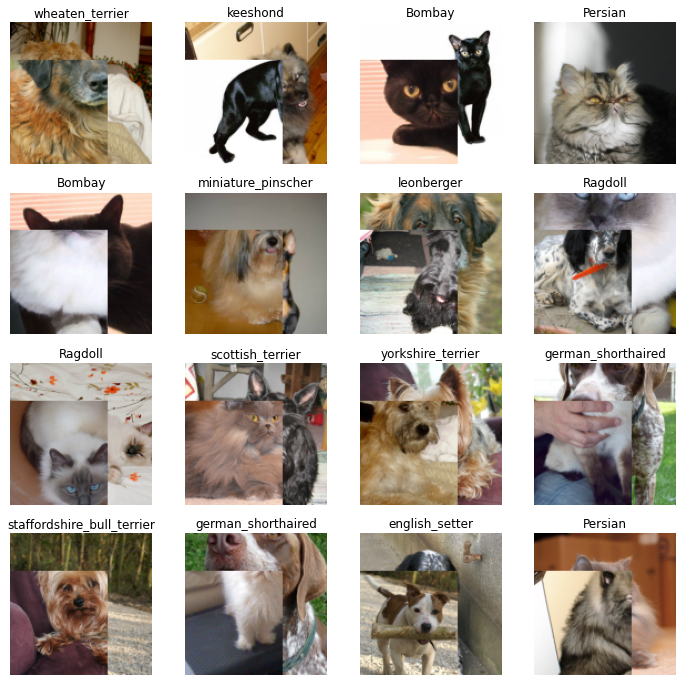

In [ ]:
#|slow
with less_random():
    cutmix = CutMixUp(cutmix_ratio=1, mixup_ratio=0, element=False)
    test_cutmixup(cutmix)

CutMix with random cuts

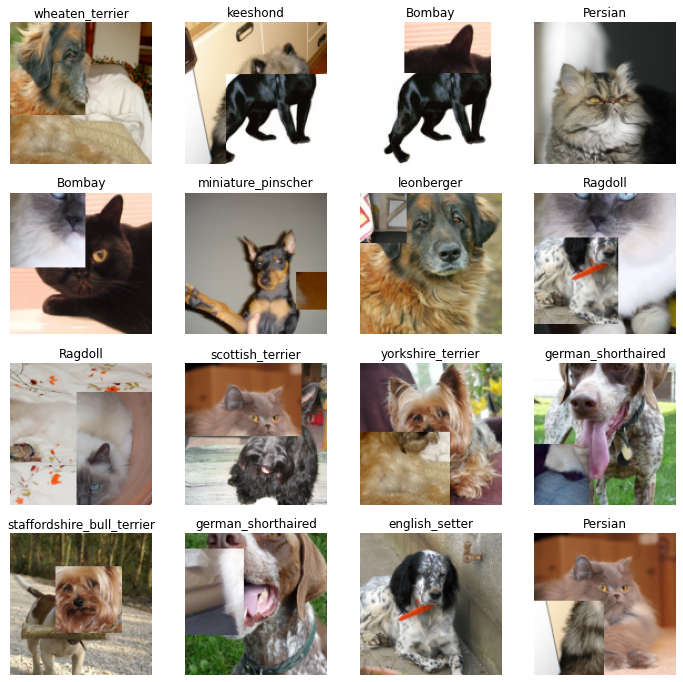

In [ ]:
#|slow
with less_random():
    cutmix = CutMixUp(cutmix_ratio=1, mixup_ratio=0, cutmix_uniform=False, element=False)
    test_cutmixup(cutmix)

MixUp

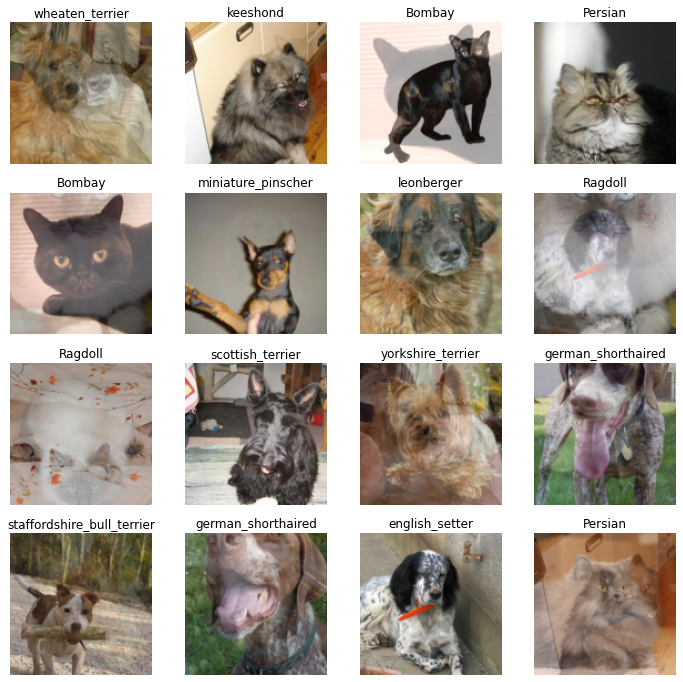

In [ ]:
#|slow
with less_random():
    mixup = CutMixUp(mix_alpha=1., cutmix_ratio=0, mixup_ratio=1, element=False)
    test_cutmixup(mixup)

CutMix and MixUp on the same batch

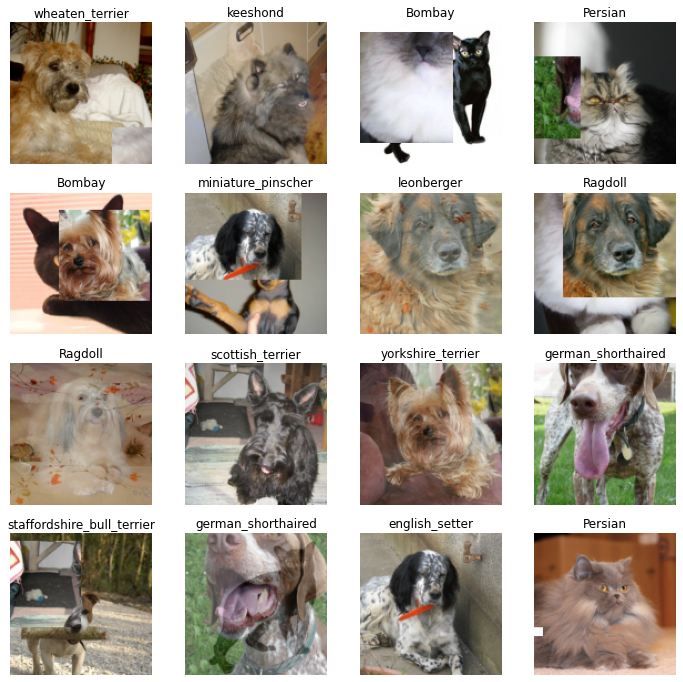

In [ ]:
#|slow
with less_random():
    mixup = CutMixUp(mix_alpha=1., cutmix_ratio=1, mixup_ratio=1)
    test_cutmixup(mixup)

## CutMixAugment Examples

CutMix with weak augmentations

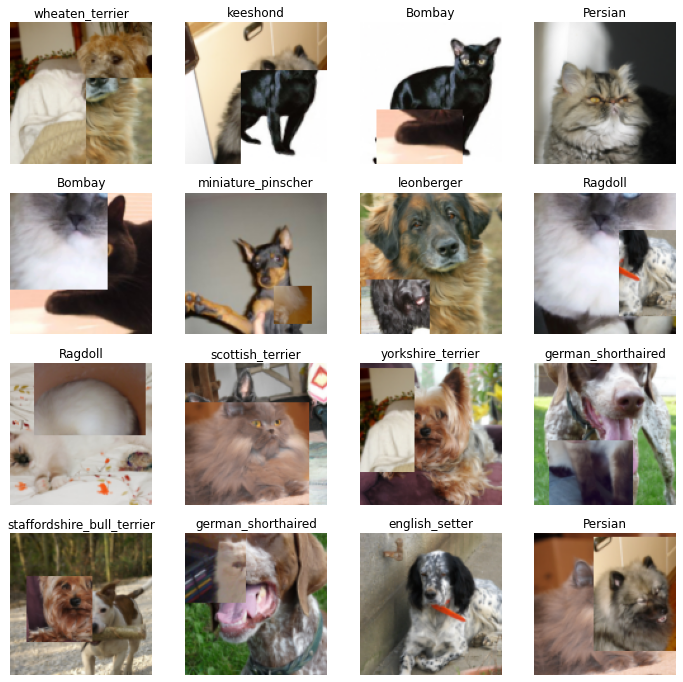

In [ ]:
#|slow
with less_random():
    cutmix = CutMixUpAugment(cutmix_ratio=1, mixup_ratio=0, augment_ratio=0, cutmix_uniform=False,
                             cutmixup_augs=aug_transforms(size=112, max_warp=0.1, max_lighting=0.1),
                             element=False)
    test_cutmixup(cutmix, True, size=112)

MixUp with weak augmentations

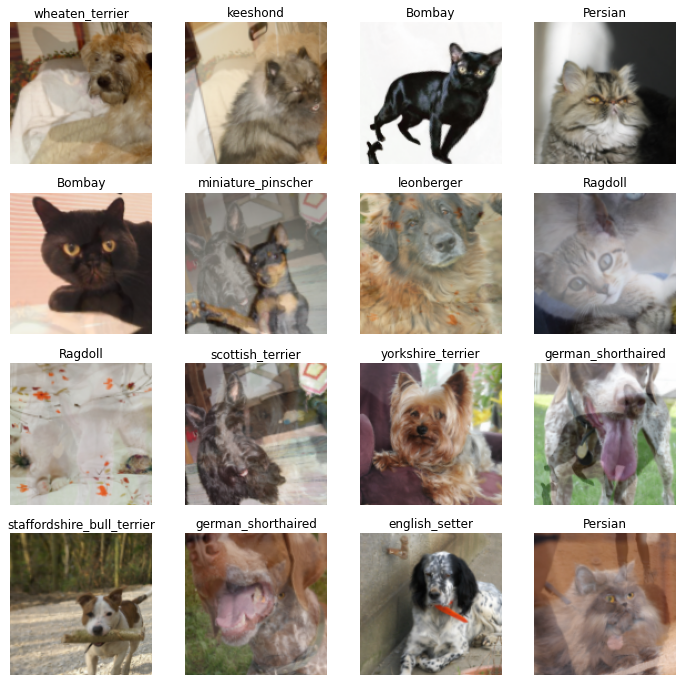

In [ ]:
#|slow
with less_random():
    mixup = CutMixUpAugment(mix_alpha=1., cutmix_ratio=0, mixup_ratio=1, augment_ratio=0,
                            cutmixup_augs=aug_transforms(max_rotate=20),
                            element=False)
    test_cutmixup(mixup, True)

Just the strong Augmentations

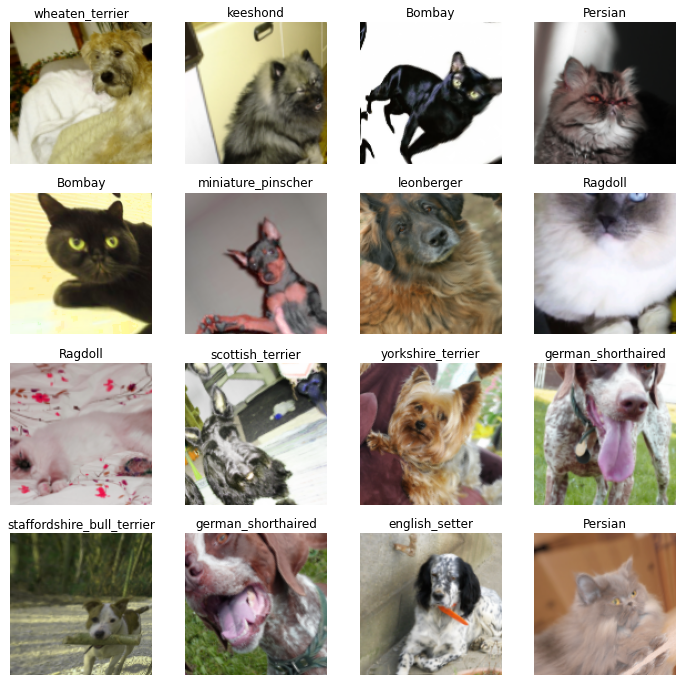

In [ ]:
#|slow
with less_random():
    augment = CutMixUpAugment(cutmix_ratio=0, mixup_ratio=0, augment_ratio=1, element=False)
    test_cutmixup(augment, True)

Mixup, CutMix, and strong Augmentations on the same batch

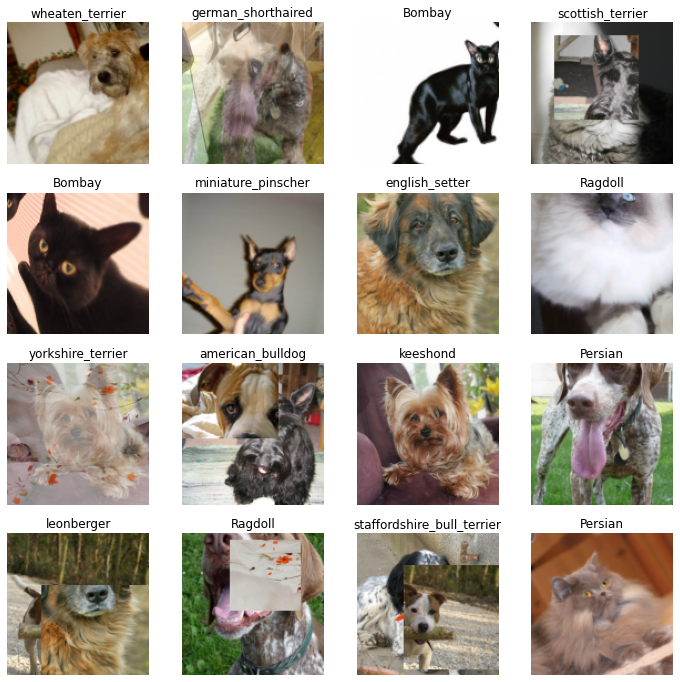

In [ ]:
#|slow
with less_random():
    batch = CutMixUpAugment(mix_alpha=1., cutmix_ratio=1, mixup_ratio=1, augment_ratio=1, cutmix_uniform=False)
    test_cutmixup(batch, True)

Mixup and CutMix with weak augmentations and strong Augmentations on the same batch

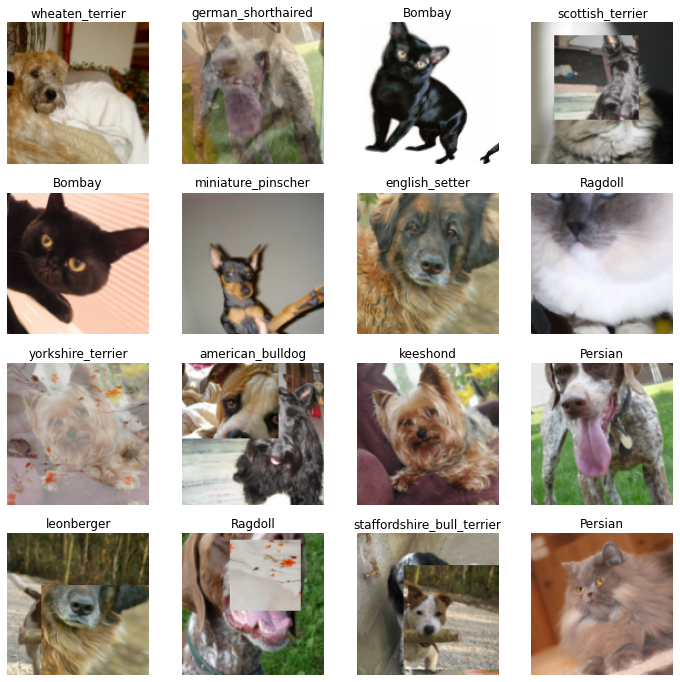

In [ ]:
#|slow
with less_random():
    batch = CutMixUpAugment(mix_alpha=1., cutmix_ratio=1, mixup_ratio=1, augment_ratio=1,
                            cutmix_uniform=False, cutmixup_augs=aug_transforms(max_rotate=20))
    test_cutmixup(batch, True)

## Tests -

In [ ]:
#|hide
#|slow
from fastcore.basics import num_cpus
from fastai.data.external import URLs, untar_data
from fastai.data.block import DataBlock, CategoryBlock
from fastai.data.transforms import GrandparentSplitter, get_image_files, parent_label, Normalize
from fastai.learner import Learner
from fastai.vision.augment import Resize, aug_transforms
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageBlock
from fastai.vision.models import resnet34
from fastxtend.callback.channelslast import *
from fastxtend.utils import *

In [ ]:
#|hide
#|slow
#|cuda
imagenette = untar_data(URLs.IMAGENETTE_160)

with less_random():
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        splitter=GrandparentSplitter(valid_name='val'),
                        get_items=get_image_files, get_y=parent_label,
                        item_tfms=Resize(128),
                        batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders(imagenette, bs=128, num_workers=num_cpus(), pin_memory=True)

    learn = Learner(dls, resnet34(num_classes=dls.c), cbs=CutMixUp(element=False)).to_channelslast()
    learn.fit_one_cycle(1, 3e-3)
    free_gpu_memory(learn, dls)

In [ ]:
#|hide
#|slow
#|cuda
imagenette = untar_data(URLs.IMAGENETTE_160)

with less_random():
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        splitter=GrandparentSplitter(valid_name='val'),
                        get_items=get_image_files, get_y=parent_label,
                        item_tfms=Resize(128),
                        batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders(imagenette, bs=128, num_workers=num_cpus(), pin_memory=True)

    learn = Learner(dls, resnet34(num_classes=dls.c), cbs=CutMixUp(cutmix_uniform=True)).to_channelslast()
    learn.fit_one_cycle(1, 3e-3)
    free_gpu_memory(learn, dls)

In [ ]:
#|hide
#|slow
#|cuda
imagenette = untar_data(URLs.IMAGENETTE_160)

with less_random():
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        splitter=GrandparentSplitter(valid_name='val'),
                        get_items=get_image_files, get_y=parent_label,
                        item_tfms=Resize(128),
                        batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders(imagenette, bs=128, num_workers=num_cpus(), pin_memory=True)

    learn = Learner(dls, resnet34(num_classes=dls.c), cbs=CutMixUp(cutmix_uniform=False)).to_channelslast()
    learn.fit_one_cycle(1, 3e-3)
    free_gpu_memory(learn, dls)

In [ ]:
#|hide
#|slow
#|cuda
imagenette = untar_data(URLs.IMAGENETTE_160)

with less_random():
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        splitter=GrandparentSplitter(valid_name='val'),
                        get_items=get_image_files, get_y=parent_label,
                        item_tfms=Resize(128),
                        batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders(imagenette, bs=128, num_workers=num_cpus(), pin_memory=True)

    learn = Learner(dls, resnet34(num_classes=dls.c),
                    cbs=CutMixUpAugment(cutmix_uniform=True, cutmixup_augs=aug_transforms())).to_channelslast()
    learn.fit_one_cycle(1, 3e-3)
    free_gpu_memory(learn, dls)

In [ ]:
#|hide
#|slow
#|cuda
imagenette = untar_data(URLs.IMAGENETTE_160)

with less_random():
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        splitter=GrandparentSplitter(valid_name='val'),
                        get_items=get_image_files, get_y=parent_label,
                        item_tfms=Resize(128),
                        batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders(imagenette, bs=128, num_workers=num_cpus(), pin_memory=True)

    learn = Learner(dls, resnet34(num_classes=dls.c), cbs=CutMixUpAugment(cutmix_uniform=False, element=False)).to_channelslast()
    learn.fit_one_cycle(1, 3e-3)
    free_gpu_memory(learn, dls)